In [1]:
# Author: James Meehan
# Date: 8/15/2018
# Description: Machine learning model to Predict Week 1 2018 fantasy scores for kickers

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# pull in data, separate into data stack, labels, and actual scores
df = pd.read_csv('Kickerstack2018.csv', sep=',', )
pts_targets = df
labels = df

labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'rating':'gt50_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values
df.shape
print(df)

[[  5.   0. 143. ...   1.   1.   0.]
 [  5.   1. 102. ...   0.   0.   0.]
 [  5.   0. 117. ...   3.   3.   2.]
 ...
 [ 19.   1. 121. ...   3.   3.   0.]
 [ 22.   1. 148. ...   3.   3.   0.]
 [ 28.   1. 119. ...   5.   3.   0.]]


In [3]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into training and test groups (80% training / 20% testing)
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]

[[-1.1928633  -1.00489599  1.02227569 ... -0.7411084  -0.55168681
  -0.45473185]
 [-1.1928633   0.99512786 -0.7602153  ... -1.49288765 -1.34971131
  -0.45473185]
 [-1.1928633  -1.00489599 -0.10808445 ...  0.76245012  1.04436219
   4.0595152 ]
 ...
 [ 0.72099252  0.99512786  0.06581711 ...  0.76245012  1.04436219
  -0.45473185]
 [ 1.13110448  0.99512786  1.23965264 ...  0.76245012  1.04436219
  -0.45473185]
 [ 1.9513284   0.99512786 -0.02113367 ...  2.26600863  1.04436219
  -0.45473185]]


In [4]:
print("Training set: {}".format(train_inputs.shape))  # 1310 examples, 24 features
print("Testing set:  {}".format(test_inputs.shape))   # 328 examples, 24 features

Training set: (1310, 24)
Testing set:  (328, 24)


In [5]:
# build the neural network.  1 hidden layer with 20 neurons.
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
  # keras.layers.Dense(20, activation=tf.nn.relu),
  # keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.002)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

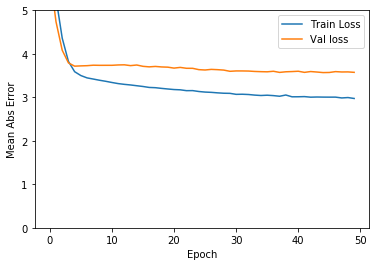

In [8]:
# graph training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

In [9]:
# calculate performance
[loss, mae] = model.evaluate(test_inputs[:-10], test_targets[:-10], verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    3.66
Testing set Mean Squared Error:   21.69


In [10]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()

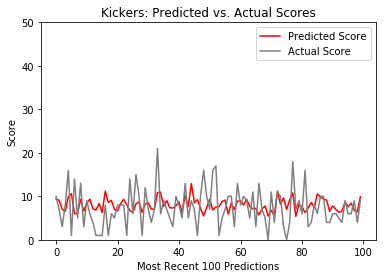

In [11]:
# grpah predictions vs. actual scores
def plot_predict():
  plt.figure()
  plt.title('Kickers: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[216:316]), label = "Predicted Score",color="red")
  plt.plot(np.array(test_targets[216:316]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [12]:
# get 2018 predictions
predict2018 = test_predictions[-10:]
Ktest_labels = labels[-10:]

fullList = []

for i in range(0, len(predict2018)):
    mylist = []
    mylist.append(Ktest_labels[i][0])
    mylist.append(Ktest_labels[i][1])
    mylist.append(int(Ktest_labels[i][2]))
    mylist.append(int(Ktest_labels[i][3]))
    mylist.append(0)
    mylist.append(predict2018[i])
    fullList.append(mylist)
print (fullList)

[['Chris', 'Boswell', 1, 2018, 0, 9.034925], ['Greg', 'Zuerlein', 1, 2018, 0, 11.21442], ['Stephen', 'Gostkowski', 1, 2018, 0, 8.805497], ['Matt', 'Bryant', 1, 2018, 0, 8.887028], ['Matt', 'Prater', 1, 2018, 0, 9.650903], ['Justin', 'Tucker', 1, 2018, 0, 9.423154], ['Robbie', 'Gould', 1, 2018, 0, 12.345966], ['Graham', 'Gano', 1, 2018, 0, 6.97316], ['Will', 'Lutz', 1, 2018, 0, 8.323889], ['Adam', 'Vinatieri', 1, 2018, 0, 8.340404]]


In [13]:
# put predictions in a csv for easy placement into the database
import csv
from pandas import read_csv 

with open("K2018Output.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
Kformat = read_csv('K2018Output.csv', sep=',', names=['fname', 'lname', 'week', 'yr', 'actual', 'predicted'])       
Kformat.to_csv('K2018Output.csv', index=False)

In [14]:
# set up database connection
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [15]:
#Create cursor with which to execute queries
cur = conn.cursor()

In [16]:
#parse csv
with open ('K2018Output.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Chris', 'Boswell', '1', '2018', '0', '9.034925')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Greg', 'Zuerlein', '1', '2018', '0', '11.21442')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Stephen', 'Gostkowski', '1', '2018', '0', '8.805497')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Matt', 'Bryant', '1', '2018', '0', '8.887027999999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Matt', 'Prater', '1', '2018', '0', '9.650903')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Justin', 'Tucker', '1', '2018', '0', '9.423153999999998')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Robbie', 'Gould', '1', '2018', '0', '12.345966')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES ('Graham